In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import scipy.stats
# import math

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

from sklearn.svm import LinearSVC

from sklearn.preprocessing import Imputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
# from sklearn.metrics import r2_score

%matplotlib inline

From the dataset documentation, columns are labeled like so:

1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)

In [2]:
url_path = 'http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
column_names = ['id', 'clump_thickness', 'size_uniformity', 'shape_uniformity', 'marginal_adhesion',
                'epithel_size', 'bare_nuclei', 'bland_chroma', 'normal_nucl', 'mitoses', 'malignant']
df_raw = pd.read_csv(url_path, header=None, names=column_names)
df_raw.head()

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithel_size,bare_nuclei,bland_chroma,normal_nucl,mitoses,malignant
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id                   699 non-null int64
clump_thickness      699 non-null int64
size_uniformity      699 non-null int64
shape_uniformity     699 non-null int64
marginal_adhesion    699 non-null int64
epithel_size         699 non-null int64
bare_nuclei          699 non-null object
bland_chroma         699 non-null int64
normal_nucl          699 non-null int64
mitoses              699 non-null int64
malignant            699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


In [4]:
df_raw.bare_nuclei.value_counts()

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

The dataset documentation said there were some question marks in the data! Since we need to keep as much data as possible, let's impute the median values.

In [5]:
# Since the stupid question mark makes the column into dtype: object,
# finding the median is a bit of a pain with Pandas. I'm doing it this way.
list_for_median = []
for each in df_raw.bare_nuclei:
    try:
        list_for_median.append(int(each))
    except:
        pass
bare_nuclei_median = int(np.median(list_for_median))

df_raw.loc[:, 'bare_nuclei'].replace('?', bare_nuclei_median, inplace=True)
df_raw.loc[:, 'bare_nuclei'] = df_raw['bare_nuclei'].astype(str).astype(int)
df_raw.bare_nuclei.describe()

count    699.000000
mean       3.486409
std        3.621929
min        1.000000
25%        1.000000
50%        1.000000
75%        5.000000
max       10.000000
Name: bare_nuclei, dtype: float64

In [6]:
df_raw.bare_nuclei.value_counts()

1     418
10    132
5      30
2      30
3      28
8      21
4      19
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

There, the question marks are all gone and now we have dtype: int64.

In [7]:
# Check for imbalanced classes. We are good here.
df_raw.malignant.value_counts()

2    458
4    241
Name: malignant, dtype: int64

In [8]:
df_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,699.0,1.071704e+06,617095.729819,61634.0,870688.5,1171710.0,1238298.0,13454352.0
clump_thickness,699.0,4.417740e+00,2.815741,1.0,2.0,4.0,6.0,10.0
size_uniformity,699.0,3.134478e+00,3.051459,1.0,1.0,1.0,5.0,10.0
shape_uniformity,699.0,3.207439e+00,2.971913,1.0,1.0,1.0,5.0,10.0
marginal_adhesion,699.0,2.806867e+00,2.855379,1.0,1.0,1.0,4.0,10.0
epithel_size,699.0,3.216023e+00,2.214300,1.0,2.0,2.0,4.0,10.0
bare_nuclei,699.0,3.486409e+00,3.621929,1.0,1.0,1.0,5.0,10.0
bland_chroma,699.0,3.437768e+00,2.438364,1.0,2.0,3.0,5.0,10.0
normal_nucl,699.0,2.866953e+00,3.053634,1.0,1.0,1.0,4.0,10.0
mitoses,699.0,1.589413e+00,1.715078,1.0,1.0,1.0,1.0,10.0


In [9]:
# Check for missing data. We are good here, too.
df_raw.isnull().sum()

id                   0
clump_thickness      0
size_uniformity      0
shape_uniformity     0
marginal_adhesion    0
epithel_size         0
bare_nuclei          0
bland_chroma         0
normal_nucl          0
mitoses              0
malignant            0
dtype: int64

In [10]:
for i in range(len(df_raw)):
    if df_raw.bare_nuclei.loc[i] == 0:
        print(i)

In [14]:
# Make new dataframe for feature creation and modification
df_features = df_raw.copy()

# Modify class index to 0,1 instead of 2,4
df_features.loc[:, 'malignant'] = ((df_raw['malignant'] / 2) -1).astype(int)
df_features.head()

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithel_size,bare_nuclei,bland_chroma,normal_nucl,mitoses,malignant
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


It looks like this dataset is already very clean, but very small. We will have to be sure to avoid overfitting, so I think it would be wise to pick our best algortithm using cross validation.

Let's explore some features, shall we?

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


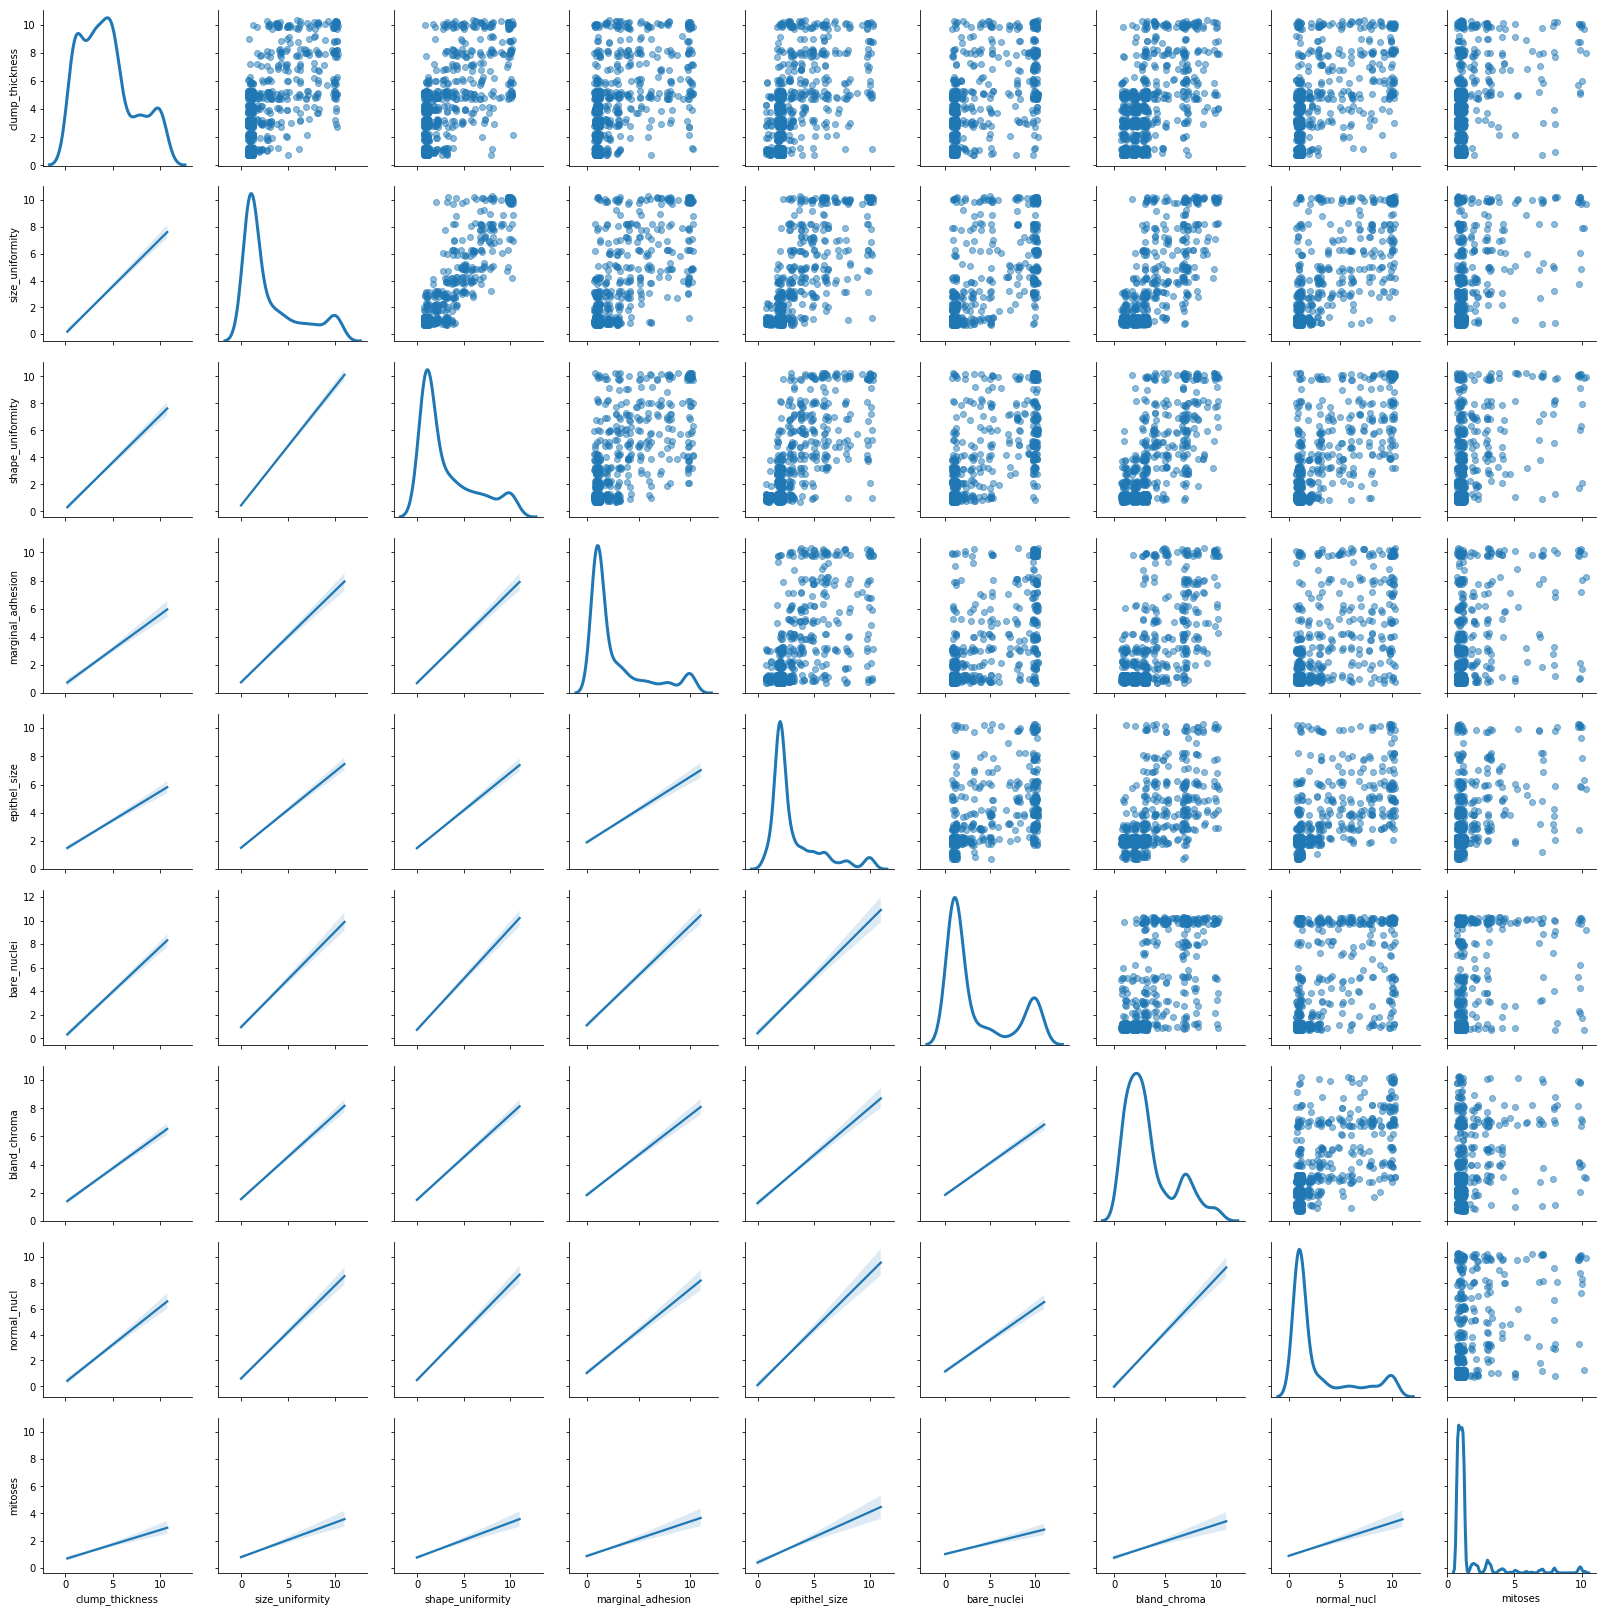

In [18]:
# Make a copy of the data to add jitter to and plot.
df_jittered = df_features.loc[:, 'clump_thickness':'mitoses']
# Making the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)
# Combine the data and the noise.
df_jittered = df_jittered.add(jitter)

# Declare that you want to make a scatterplot matrix.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

FLow Chart: Linear SVC, then KNeighbors, then SVC and Ensemble methods

                   clump_thickness  size_uniformity  shape_uniformity  \
clump_thickness           1.000000         0.644913          0.654589   
size_uniformity           0.644913         1.000000          0.906882   
shape_uniformity          0.654589         0.906882          1.000000   
marginal_adhesion         0.486356         0.705582          0.683079   
epithel_size              0.521816         0.751799          0.719668   
bare_nuclei               0.590008         0.686673          0.707474   
bland_chroma              0.558428         0.755721          0.735948   
normal_nucl               0.535835         0.722865          0.719446   
mitoses                   0.350034         0.458693          0.438911   
malignant                 0.716001         0.817904          0.818934   

                   marginal_adhesion  epithel_size  bare_nuclei  bland_chroma  \
clump_thickness             0.486356      0.521816     0.590008      0.558428   
size_uniformity             0.7055

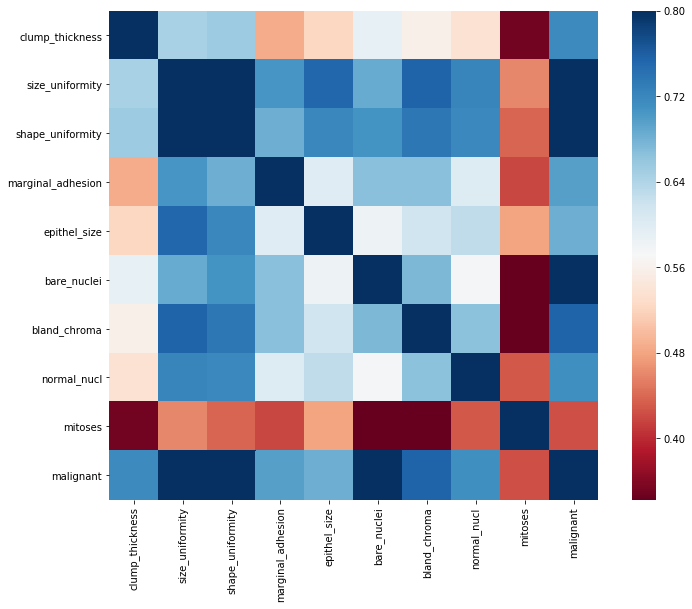

In [30]:
# Make the correlation matrix.
corrmat = df_features.drop('id', 1).corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))
sns.color_palette("RdBu", n_colors=7)

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True, cmap="RdBu")
plt.show()
# Heatmaps are a great way to get a quick visual read on a big correlation matrix.

# Try to match the correlation numbers to the scatterplots above to get a 
# sense of what each magnitude of correlation can look like.


In [100]:
X = df_features.drop(['id', 'malignant'], 1)
y = df_features.malignant

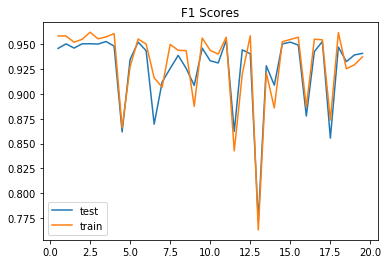

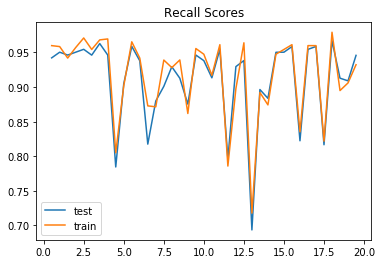

In [97]:
cross_val_scores = []
best_i = None

i_start, i_stop, i_step = .5, 20, .5
for i in np.arange(i_start, i_stop, i_step):
    lin_svc = LinearSVC(C=i)
    cross_val_scores.append(cross_validate(lin_svc, X, y, cv=4, scoring=['f1', 'recall'], return_train_score=True))

    
test_f1 = []
train_f1 = []
test_recall = []
train_recall = []
for scores in cross_val_scores:
    test_f1.append(scores['test_f1'].mean())
    train_f1.append(scores['train_f1'].mean())
    test_recall.append(scores['test_recall'].mean())
    train_recall.append(scores['train_recall'].mean())


    
plt.figure()
plt.title('F1 Scores')
plt.plot(np.arange(i_start, i_stop, i_step), test_f1, label='test')
plt.plot(np.arange(i_start, i_stop, i_step), train_f1, label='train')
plt.legend()

plt.figure()
plt.title('Recall Scores')
plt.plot(np.arange(i_start, i_stop, i_step), test_recall, label='test')
plt.plot(np.arange(i_start, i_stop, i_step), train_recall, label='train')
plt.legend()

plt.show()


In [103]:
cross_val_scores = []
best_i = None

print(y)

i_start, i_stop, i_step = .5, 20, .5
for i in np.arange(i_start, i_stop, i_step):
    lass = Lasso(alpha=i)
    print(i)
    cross_val_scores.append(cross_validate(lass, X, y, cv=4, scoring=['f1', 'recall'], return_train_score=True))

    
test_f1 = []
train_f1 = []
test_recall = []
train_recall = []
for scores in cross_val_scores:
    test_f1.append(scores['test_f1'].mean())
    train_f1.append(scores['train_f1'].mean())
    test_recall.append(scores['test_recall'].mean())
    train_recall.append(scores['train_recall'].mean())


    
plt.figure()
plt.title('F1 Scores')
plt.plot(np.arange(i_start, i_stop, i_step), test_f1, label='test')
plt.plot(np.arange(i_start, i_stop, i_step), train_f1, label='train')
plt.legend()

plt.figure()
plt.title('Recall Scores')
plt.plot(np.arange(i_start, i_stop, i_step), test_recall, label='test')
plt.plot(np.arange(i_start, i_stop, i_step), train_recall, label='train')
plt.legend()

plt.show()


0      0
1      0
2      0
3      0
4      0
5      1
6      0
7      0
8      0
9      0
10     0
11     0
12     1
13     0
14     1
15     1
16     0
17     0
18     1
19     0
20     1
21     1
22     0
23     1
24     0
25     1
26     0
27     0
28     0
29     0
      ..
669    1
670    1
671    0
672    0
673    0
674    0
675    0
676    0
677    0
678    0
679    0
680    1
681    1
682    0
683    0
684    0
685    0
686    0
687    0
688    0
689    0
690    0
691    1
692    0
693    0
694    0
695    0
696    1
697    1
698    1
Name: malignant, Length: 699, dtype: int32
0.5


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
lin_svr.